A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

In [34]:
from io import open
import glob
import os

import unicodedata
import string

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [35]:
print(glob.glob('./data/names/*.txt'))

['./data/names/Arabic.txt', './data/names/Chinese.txt', './data/names/Czech.txt', './data/names/Dutch.txt', './data/names/English.txt', './data/names/French.txt', './data/names/German.txt', './data/names/Greek.txt', './data/names/Irish.txt', './data/names/Italian.txt', './data/names/Japanese.txt', './data/names/Korean.txt', './data/names/Polish.txt', './data/names/Portuguese.txt', './data/names/Russian.txt', './data/names/Scottish.txt', './data/names/Spanish.txt', './data/names/Vietnamese.txt']


Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

In [36]:
all_letters = string.ascii_letters + ',.;'
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if c in all_letters and unicodedata.category(c) != 'Mn'
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [37]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [38]:
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


### Turning Names into Tensors
To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.  

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.  

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [39]:
def letterToIndex(letter):
    return all_letters.find(letter)

# turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for (i, letter) in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Creating the Network
This RNN module implements a “vanilla RNN” an is just 3 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.  
To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        '''
        This line is where the feedback loop happens. The new hidden state is computed as a function of the current input (self.i2h(input)) and the previous hidden state (self.h2h(hidden)). By adding these two components together and applying a non-linearity (F.tanh in this case), the network is able to update its hidden state in a way that depends on both the new input and the previous state.
        '''
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        out = self.h2o(hidden)
        out = self.activation(out)
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

        

In [41]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [42]:
input = letterToTensor('N')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8912, -2.9385, -2.9119, -2.7940, -2.9940, -2.7527, -2.9530, -2.7097,
         -2.8388, -2.9608, -2.9887, -2.8610, -2.8155, -2.8670, -2.9278, -3.0249,
         -2.9291, -2.9317]], grad_fn=<LogSoftmaxBackward0>)


For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by precomputing batches of Tensors.

In [43]:
input = lineToTensor('Nitesh')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8912, -2.9385, -2.9119, -2.7940, -2.9940, -2.7527, -2.9530, -2.7097,
         -2.8388, -2.9608, -2.9887, -2.8610, -2.8155, -2.8670, -2.9278, -3.0249,
         -2.9291, -2.9317]], grad_fn=<LogSoftmaxBackward0>)


In [44]:
def pred_fn(output_tensor):
    max_i = torch.argmax(output_tensor).item()
    return all_categories[max_i], max_i

pred_fn(output)
    

('Greek', 7)

### Training the network
For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

Each loop of training will:
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
    - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [45]:
import torch.optim as optim
lr = 0.005
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=lr)

# basically we have a line and the category of language to which it belongs
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    optimizer.zero_grad()

    # tensor size if line_length x 1 x n_letters. We need to iterate over the line.
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()



In [46]:
def random_example():
    category = all_categories[random.randint(0, len(all_categories) - 1)]
    line = category_lines[category][random.randint(0, len(category_lines[category]) - 1)]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


In [48]:
n_iters = 100000
print_every = 5000

losses = []
cur_loss = 0

for i in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = random_example()
    output, loss = train(category_tensor, line_tensor)
    cur_loss += loss
    if i%print_every == 0:
        losses.append(cur_loss/print_every)
        cur_loss = 0


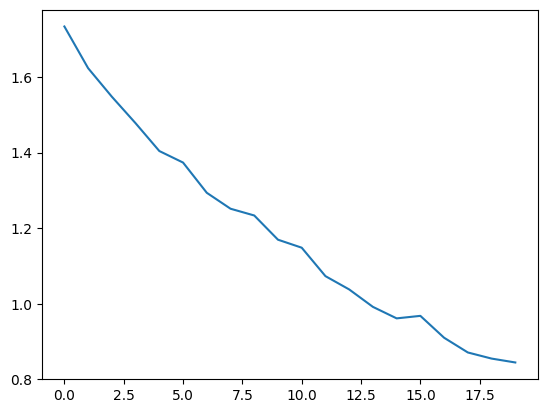

In [49]:
plt.figure()
plt.plot(losses)

In [50]:
def predict(input_line, n_predictions=3):
    print(f'> {input_line}')
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        hidden = rnn.initHidden()
        for i in range(input_tensor.size()[0]):
            output, hidden = rnn(input_tensor[i], hidden)
        
        topv, topi = output.topk(n_predictions, 1, True)
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'{all_categories[category_index]} ({value})')

In [51]:
predict('Dovesky')

> Dovesky
Czech (-0.34086477756500244)
Russian (-1.6500598192214966)
French (-3.2212114334106445)


In [52]:
predict('Jackson')

> Jackson
Scottish (-0.16187280416488647)
Russian (-2.672788143157959)
English (-3.5559072494506836)


In [53]:
predict('Satoshi')

> Satoshi
Japanese (-0.0706249475479126)
Arabic (-3.1414480209350586)
Italian (-4.397721767425537)


In [56]:
predict('Salman')

> Salman
French (-0.9546606540679932)
Arabic (-1.1929538249969482)
Irish (-1.8531239032745361)
